<a href="https://colab.research.google.com/github/mili189/ASK2026_Semiconductor_FDC/blob/main/Original_%EC%A0%84%EC%B2%98%EB%A6%AC_LSTM_Autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
import os


drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from scipy.interpolate import interp1d

# Machine Data 로드
file_path = ("/content/drive/MyDrive/Colab Notebooks/data set/MACHINE_data/MACHINE_Data.xlsx")

# 파일 로드
if os.path.exists(file_path):
    print(f"{file_path}")
    if file_path.endswith('.xlsx'):
        df = pd.read_excel(file_path)
    elif file_path.endswith('.csv'):
        df = pd.read_csv(file_path)
    else:
        print("지원하지 않는 파일 형식입니다.")
else:
    raise FileNotFoundError(f"File not found: {file_path}")

print(f"Machine Data 로드 완료. Shape: {df.shape}")

# 식별 및 정답 Column
meta_cols = ['Wafer_ID', 'Time_Step', 'Label', 'Fault_Type', 'Time', 'Step Number']

# 학습에 사용할 센서 변수 선택 (숫자형 데이터만 선택)
sensor_cols = [c for c in df.columns if c not in meta_cols]
# 문자열 데이터 필터링 추가
sensor_cols = df[sensor_cols].select_dtypes(include=[np.number]).columns.tolist()

print(f"선택된 센서 변수 ({len(sensor_cols)}개):")
print(sensor_cols)

/content/drive/MyDrive/Colab Notebooks/data set/MACHINE_data/MACHINE_Data.xlsx
Machine Data 로드 완료. Shape: (12829, 25)
선택된 센서 변수 (19개):
['BCl3 Flow', 'Cl2 Flow', 'RF Btm Pwr', 'RF Btm Rfl Pwr', 'Endpt A', 'He Press', 'Pressure', 'RF Tuner', 'RF Load', 'RF Phase Err', 'RF Pwr', 'RF Impedance', 'TCP Tuner', 'TCP Phase Err', 'TCP Impedance', 'TCP Top Pwr', 'TCP Rfl Pwr', 'TCP Load', 'Vat Valve']


In [ ]:
# 1. 라벨 구성 확인
print(df['Label'].value_counts())

# 2. 실험 ID별 데이터 개수 확인
for eid in ['l29', 'l31', 'l33']:
    count = df['Wafer_ID'].str.contains(eid, case=False).sum()
    print(f"실험 {eid} 데이터 개수: {count}")

Label
Normal    10770
Fault      2059
Name: count, dtype: int64
실험 l29 데이터 개수: 4399
실험 l31 데이터 개수: 4180
실험 l33 데이터 개수: 4250


In [ ]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# 1. 전처리 함수 정의 (이 부분이 정의되어야 에러가 나지 않습니다)
def preprocess_sensor_data(raw_data, seq_len=100):
    """
    논문 방식 전처리:
    1. MinMaxScaler를 이용한 0~1 정규화
    2. Sliding Window를 통한 시각(Time-step) 데이터 생성
    """
    # 데이터가 비어있는지 확인
    if len(raw_data) == 0:
        return np.array([]), None

    # 정규화 (Min-Max Scaling)
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(raw_data)

    # 시퀀스 생성 (Sliding Window)
    sequences = []
    for i in range(len(scaled_data) - seq_len + 1):
        sequences.append(scaled_data[i:i + seq_len])

    return np.array(sequences), scaler

# 1. 실험 ID 리스트 정의 (이 부분이 누락되었습니다)
experiments = ['l29', 'l31', 'l33']

# 2. 전처리 결과를 담을 딕셔너리 초기화
datasets = {}

# 3. 이제 루프를 시작합니다

for exp_id in experiments:
    # 1. 해당 실험 데이터 추출 (Wafer_ID 필터링)
    exp_df = df[df['Wafer_ID'].str.contains(exp_id, case=False, na=False)]

    if exp_df.empty:
        print(f"⚠️ [{exp_id}] 데이터가 비어있습니다. 건너뜁니다.")
        continue

    # 2. 라벨에 따른 데이터 분리 (문자열로 수정!)
    train_df = exp_df[exp_df['Label'] == 'Normal']
    test_fault_df = exp_df[exp_df['Label'] == 'Fault']

    # 디버깅용 출력 추가
    print(f"🔍 [{exp_id}] 필터링 결과: Normal={len(train_df)}개, Fault={len(test_fault_df)}개")

    # 데이터 개수 확인 (seq_len=100 기준)
    if len(train_df) < 100:
        print(f"⚠️ [{exp_id}] 정상 데이터 부족으로 전처리를 진행할 수 없습니다.")
        continue

    # 3. 센서 데이터 추출
    train_raw = train_df[sensor_cols].values
    test_fault_raw = test_fault_df[sensor_cols].values if not test_fault_df.empty else np.array([])

    # 4. 전처리 함수 적용 (정상 데이터 학습용)
    X_train, scaler = preprocess_sensor_data(train_raw, seq_len=100)

    # 5. 불량 데이터 처리 (테스트용)
    X_test_fault = []
    if len(test_fault_raw) >= 100:
        # 학습 시 사용한 scaler로 정규화
        scaled_fault = scaler.transform(test_fault_raw)
        # 슬라이딩 윈도우 생성
        for i in range(len(scaled_fault) - 100 + 1):
            X_test_fault.append(scaled_fault[i:i + 100])
        X_test_fault = np.array(X_test_fault)
    else:
        X_test_fault = np.array([])

    # 6. 결과 저장 (이후 루프에서 사용될 datasets 딕셔너리)
    datasets[exp_id] = {
        'train': X_train,
        'test_normal': X_train, # 논문 방식에 따라 테스트용 정상 데이터로 train 일부 사용 가능
        'test_fault': X_test_fault,
        'scaler': scaler
    }
    print(f"✅ [{exp_id}] 전처리 완료: Train {X_train.shape}, Fault {X_test_fault.shape}")

🔍 [l29] 필터링 결과: Normal=3486개, Fault=913개
✅ [l29] 전처리 완료: Train (3387, 100, 19), Fault (814, 100, 19)
🔍 [l31] 필터링 결과: Normal=3638개, Fault=542개
✅ [l31] 전처리 완료: Train (3539, 100, 19), Fault (443, 100, 19)
🔍 [l33] 필터링 결과: Normal=3646개, Fault=604개
✅ [l33] 전처리 완료: Train (3547, 100, 19), Fault (505, 100, 19)


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, accuracy_score

# 장치 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def plot_model_results(exp_id, title, y_true, y_pred, ai_scores, threshold):
    plt.figure(figsize=(10, 4))
    # 1. 혼동 행렬
    cm = confusion_matrix(y_true, y_pred, labels=[1, 0])
    plt.subplot(1, 2, 1)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Fault'], yticklabels=['Normal', 'Fault'])
    plt.title(f'[{title}] Confusion Matrix')

    # 2. AI 분포 (논문 Fig. 5 스타일)
    plt.subplot(1, 2, 2)
    indices = np.arange(len(ai_scores))
    n_norm = sum(y_true)
    plt.scatter(indices[:n_norm], ai_scores[:n_norm], color='blue', label='Healthy', alpha=0.5)
    plt.scatter(indices[n_norm:], ai_scores[n_norm:], color='red', marker='x', label='Defective')
    plt.axhline(y=threshold, color='black', linestyle='--', label='Threshold')
    plt.title(f'[{title}] AI Distribution')
    plt.legend()
    plt.tight_layout()
    plt.show()

    acc = accuracy_score(y_true, y_pred)
    print(f"👉 {title} Accuracy: {acc*100:.2f}%")
    return acc # 정확도 값을 반환하여 변수에 저장될 수 있게 함

In [ ]:
class LAM9600_LSTM_AE(nn.Module):
    def __init__(self, n_features, seq_len):
        super(LAM9600_LSTM_AE, self).__init__()
        self.seq_len = seq_len
        self.n_features = n_features

        # [Encoder] 입력 -> 64 -> 32 -> 16
        self.encoder_lstm1 = nn.LSTM(n_features, 64, batch_first=True)
        self.encoder_lstm2 = nn.LSTM(64, 32, batch_first=True)
        self.encoder_lstm3 = nn.LSTM(32, 16, batch_first=True)

        # [Decoder] 16 -> 32 -> 64 -> 입력
        self.decoder_lstm1 = nn.LSTM(16, 32, batch_first=True)
        self.decoder_lstm2 = nn.LSTM(32, 64, batch_first=True)
        self.output_layer = nn.Linear(64, n_features)

    def forward(self, x):
        _, _ = self.encoder_lstm1(x)
        enc1, _ = self.encoder_lstm1(x)
        enc2, _ = self.encoder_lstm2(enc1)
        _, (hidden, _) = self.encoder_lstm3(enc2) # Bottleneck (1, batch, 16)

        # Repeat Vector: 잠재 벡터를 시퀀스 길이만큼 복제
        repeat_x = hidden.repeat(self.seq_len, 1, 1).permute(1, 0, 2)

        dec1, _ = self.decoder_lstm1(repeat_x)
        dec2, _ = self.decoder_lstm2(dec1)
        return self.output_layer(dec2)

모델 입력 설정 완료: 시퀀스 길이=100, 센서 수=19


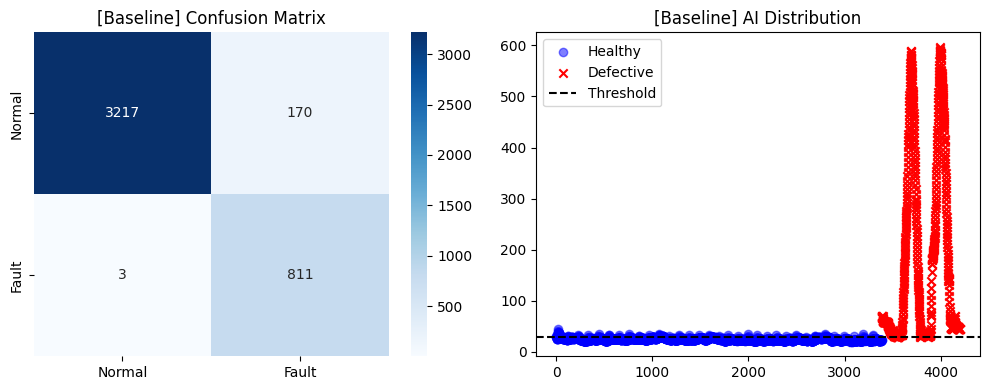

👉 Baseline Accuracy: 95.88%


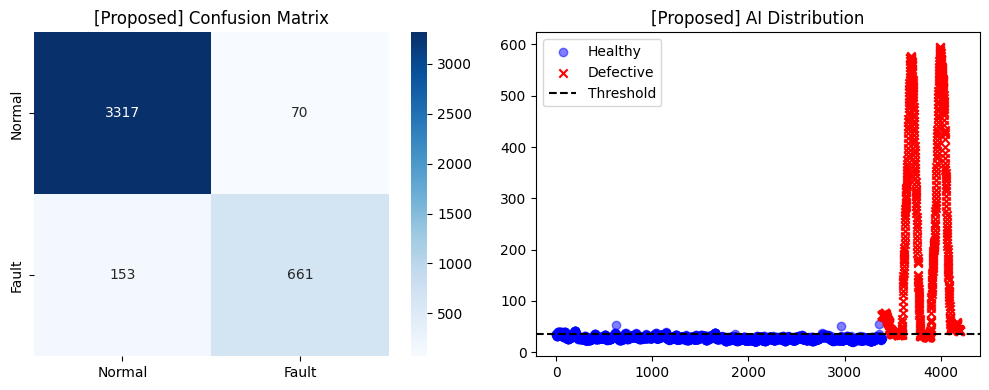

👉 Proposed Accuracy: 94.69%


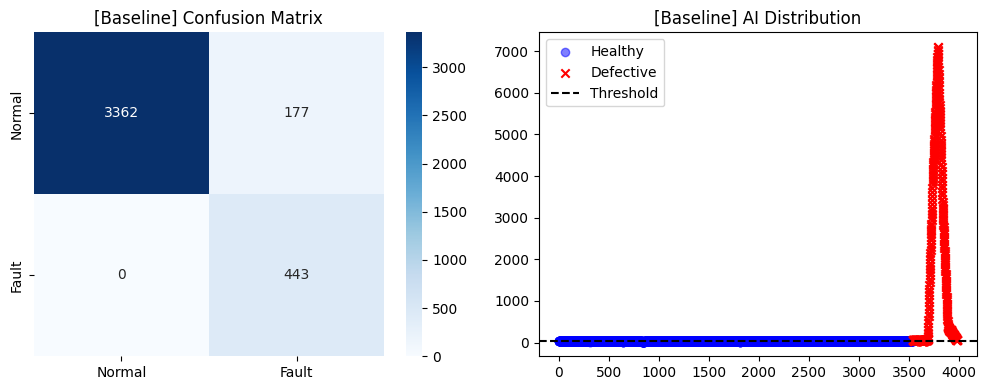

👉 Baseline Accuracy: 95.55%


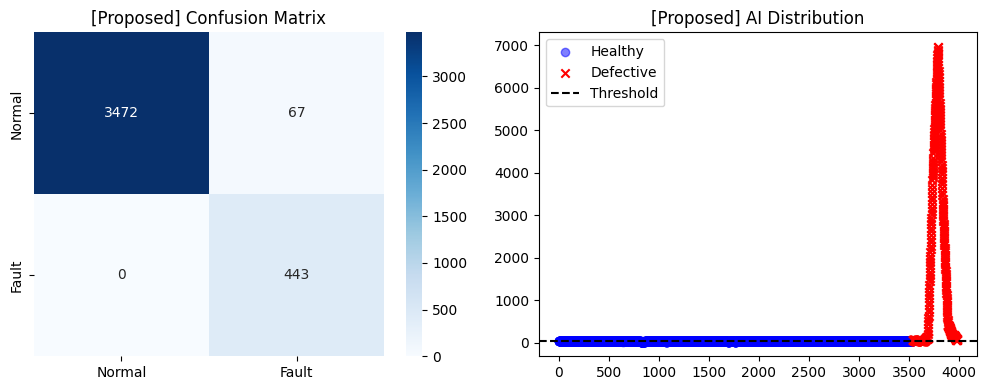

👉 Proposed Accuracy: 98.32%


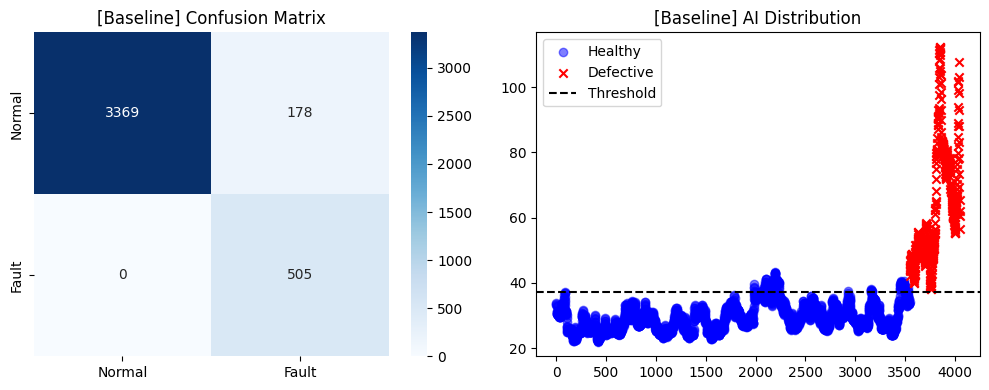

👉 Baseline Accuracy: 95.61%


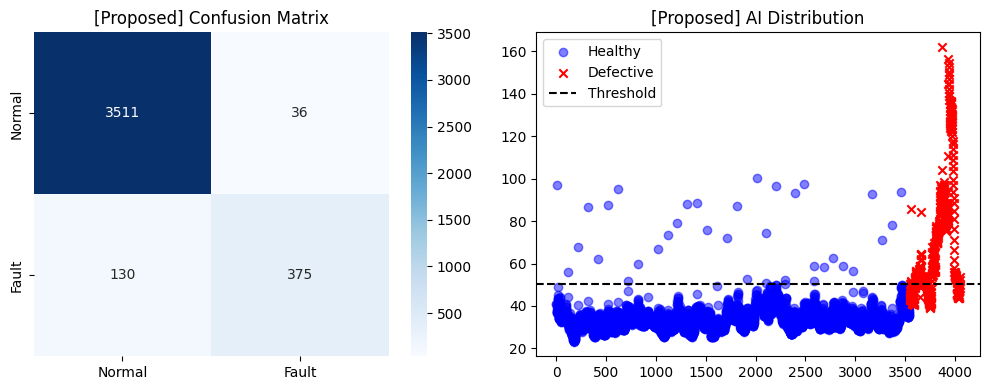

👉 Proposed Accuracy: 95.90%


In [ ]:
# 실험 설정
experiments = ['l29', 'l31', 'l33']
exp_configs = {
    'l29': {'clean_p': 98, 'thresh_p': 98, 'epochs': 100},
    'l31': {'clean_p': 99, 'thresh_p': 99, 'epochs': 100},
    'l33': {'clean_p': 99, 'thresh_p': 99, 'epochs': 100}
}
#exp_configs = {
#    'l29': {'clean_p': 85, 'thresh_p': 90, 'epochs': 50}, #제대로 작동되는지 보기 위해 에폭을 150에서 50으로 변경함.
#    'l31': {'clean_p': 95, 'thresh_p': 95, 'epochs': 50},
#    'l33': {'clean_p': 95, 'thresh_p': 95, 'epochs': 50}
#}
comparison_table = []

# --- 변수 정의 추가 ---
# 전처리된 데이터 중 하나(예: l29의 train 데이터)를 기준으로 형태를 파악합니다.
# 데이터 모양이 (샘플 수, 시퀀스 길이, 센서 수)이므로 인덱스 1과 2를 사용합니다.

sample_exp = experiments[0] # 'l29'
n_steps = datasets[sample_exp]['train'].shape[1] # 시퀀스 길이 (100)
n_feats = datasets[sample_exp]['train'].shape[2] # 센서 변수 개수

print(f"모델 입력 설정 완료: 시퀀스 길이={n_steps}, 센서 수={n_feats}")

for exp_id in experiments:
    conf = exp_configs[exp_id]
    X_train_raw = datasets[exp_id]['train'] # 이미 전처리(MinMaxScaler)된 데이터 가정
    X_test_normal = datasets[exp_id]['test_normal']
    X_test_fault = datasets[exp_id]['test_fault']

    y_true = [1] * len(X_test_normal) + [0] * len(X_test_fault)
    X_test_all = np.concatenate([X_test_normal, X_test_fault], axis=0)
    test_tensor = torch.FloatTensor(X_test_all).to(device)

    # --- [Case A] Baseline (정제 없음) ---
    model_base = LAM9600_LSTM_AE(n_feats, n_steps).to(device)
    opt_base = optim.Adam(model_base.parameters(), lr=1e-3)
    train_loader = DataLoader(TensorDataset(torch.FloatTensor(X_train_raw).to(device)), batch_size=16, shuffle=True)

    model_base.train()
    for epoch in range(100): # Baseline 공통 에폭
        for batch in train_loader:
            opt_base.zero_grad(); loss = nn.MSELoss()(model_base(batch[0]), batch[0]); loss.backward(); opt_base.step()

    model_base.eval()
    with torch.no_grad():
        tr_ai = torch.sum((torch.FloatTensor(X_train_raw).to(device) - model_base(torch.FloatTensor(X_train_raw).to(device)))**2, dim=(1, 2)).cpu().numpy()
        thresh_base = np.percentile(tr_ai, 95)
        ai_base = torch.sum((test_tensor - model_base(test_tensor))**2, dim=(1, 2)).cpu().numpy()
        pred_base = [0 if s > thresh_base else 1 for s in ai_base]
    acc_base = plot_model_results(exp_id, "Baseline", y_true, pred_base, ai_base, thresh_base)

    # --- [Case B] Proposed (10-Fold CV 정제 포함) ---
    kf = KFold(n_splits=10, shuffle=True, random_state=42)
    bad_indices = []
    for t_idx, v_idx in kf.split(X_train_raw):
        temp_m = LAM9600_LSTM_AE(n_feats, n_steps).to(device)
        t_loader = DataLoader(TensorDataset(torch.FloatTensor(X_train_raw[t_idx]).to(device)), batch_size=16)
        temp_opt = optim.Adam(temp_m.parameters(), lr=1e-3)
        for _ in range(15): # 정제용 짧은 학습. 시간을 줄이기 위해 성능의 큰 차이가 나지 않는 범위 하에 20에서 15로 줄임.
            for b in t_loader:
                loss = nn.MSELoss()(temp_m(b[0]), b[0]); temp_opt.zero_grad(); loss.backward(); temp_opt.step()
        with torch.no_grad():
            X_v = torch.FloatTensor(X_train_raw[v_idx]).to(device)
            ai_v = torch.sum((X_v - temp_m(X_v))**2, dim=(1, 2)).cpu().numpy().flatten()
            bad_indices.extend(v_idx[ai_v > np.percentile(ai_v, conf['clean_p'])])

    X_train_clean = np.delete(X_train_raw, list(set(bad_indices)), axis=0)
    model_pro = LAM9600_LSTM_AE(n_feats, n_steps).to(device)
    opt_pro = optim.Adam(model_pro.parameters(), lr=1e-3)
    pro_loader = DataLoader(TensorDataset(torch.FloatTensor(X_train_clean).to(device)), batch_size=16, shuffle=True)

    for epoch in range(conf['epochs']):
        for batch in pro_loader:
            opt_pro.zero_grad(); loss = nn.MSELoss()(model_pro(batch[0]), batch[0]); loss.backward(); opt_pro.step()

    model_pro.eval()
    with torch.no_grad():
        tr_ai_pro = torch.sum((torch.FloatTensor(X_train_clean).to(device) - model_pro(torch.FloatTensor(X_train_clean).to(device)))**2, dim=(1, 2)).cpu().numpy()
        thresh_pro = np.percentile(tr_ai_pro, conf['thresh_p'])
        ai_pro = torch.sum((test_tensor - model_pro(test_tensor))**2, dim=(1, 2)).cpu().numpy()
        pred_pro = [0 if s > thresh_pro else 1 for s in ai_pro]
    acc_pro = plot_model_results(exp_id, "Proposed", y_true, pred_pro, ai_pro, thresh_pro)

    # 만약 acc_base나 acc_pro가 None인 경우를 대비한 안전 장치
    if acc_base is not None and acc_pro is not None:
        improvement = acc_pro - acc_base
    else:
        improvement = 0.0

    comparison_table.append({
        'Exp': exp_id,
        'Baseline': acc_base,
        'Proposed': acc_pro,
        'Improvement': improvement
    })
   #처음에 시도한 코드 comparison_table.append({'Exp': exp_id, 'Baseline': acc_base, 'Proposed': acc_pro, 'Improvement': acc_pro - acc_base}) 는 acc_pro와 acc_base가 none인지 확인하지 않고 뺄셈을 시도하기 때문에 긴 시간이 걸린 데이터가 none-none가 되면 모든 데이터를 날리고 종료됨..